## LSTM Stock Forecasting

### Import Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings

warnings.filterwarnings('ignore')

### Load & Prepare Data

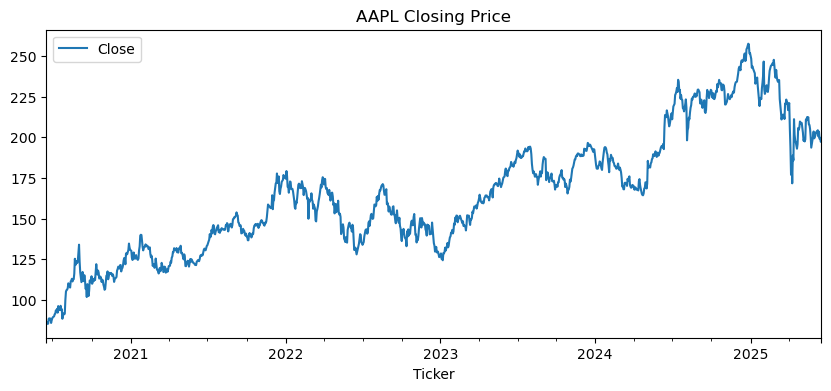

In [2]:
df = pd.read_csv('../data/AAPL.csv', header=1)
df = df[df['Ticker'] != 'Date'].copy()
df['Ticker'] = pd.to_datetime(df['Ticker'])
df.set_index('Ticker', inplace=True)
df = df.asfreq('B')
df['Close'] = pd.to_numeric(df['AAPL.3'], errors='coerce')
df['Close'].interpolate(method='linear', inplace=True)

df = df[['Close']].copy()
df.plot(title='AAPL Closing Price', figsize=(10, 4))
plt.show()

### Normalize & Prepare Sequences

In [3]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Create sequences
def create_sequences(data, window_size=90):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window_size = 90
X, y = create_sequences(scaled_data, window_size)

# Train-test split
split = int(0.85 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


### Build & Train the LSTM Model

In [4]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
    verbose=1
)


Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0717 - val_loss: 0.0053
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0047 - val_loss: 0.0033
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0034 - val_loss: 0.0040
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0032 - val_loss: 0.0033


### Forecast & Inverse Transform

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


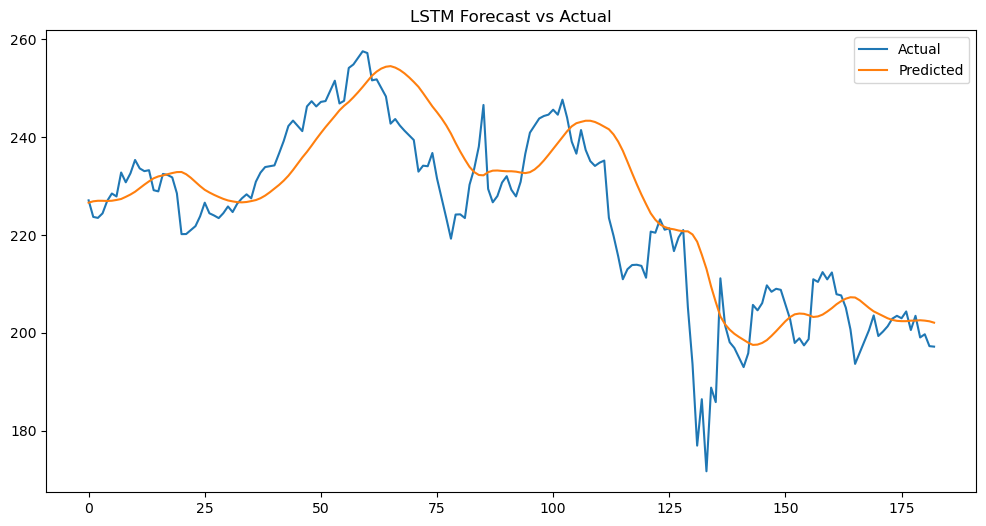

In [5]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('LSTM Forecast vs Actual')
plt.legend()
plt.show()


### Evaluate

In [6]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from evaluate_models import evaluate_forecast, print_evaluation

results = evaluate_forecast(y_test_actual.flatten(), predictions.flatten(), model_name='LSTM')
print_evaluation(results)



📊 Evaluation for LSTM
------------------------------
MAE : 7.2277
MSE : 98.3314
RMSE: 9.9162
